In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Environment Variables
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']= spark_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install pyspark
!pip install -q findspark

# Start Spark session
import findspark
import pyspark
findspark.init() 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,058 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,354 kB]
Get:14 http:

In [2]:
 # Read in data from S3 Buckets
from pyspark import SparkFiles
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrame Basics").getOrCreate()

url = "https://project-4-jeks.s3.us-east-2.amazonaws.com/airline_satisfaction.csv"
spark.sparkContext.addFile(url)
airlines = spark.read.csv(SparkFiles.get("airline_satisfaction.csv"), header=True)

# Show DataFrame using Pandas
airlines_df = airlines.toPandas()
airlines_df["satisfaction"] = airlines_df["satisfaction"].replace(['satisfied'],'1')
airlines_df["satisfaction"] = airlines_df["satisfaction"].replace(['neutral or dissatisfied'],'0')
airlines_df["satisfaction"] = airlines_df["satisfaction"].apply(pd.to_numeric)
airlines_df = airlines_df.dropna()

airlines_df = airlines_df.drop(columns=["id", "_c0"])
airlines_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44,1
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0,1
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0,0
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6,1
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20,1


In [3]:
# Create dummy variables for categorical columns
gender_dummies = pd.get_dummies(airlines_df["Gender"])
airlines_df = pd.concat([airlines_df, gender_dummies], axis=1)
airlines_df = airlines_df.drop(columns=["Gender"])
airlines_df.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Female,Male
0,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,...,5,5,2,5,5,50,44,1,1,0
1,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,...,4,4,3,4,5,0,0,1,1,0
2,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,...,1,3,2,2,2,0,0,0,0,1
3,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,...,1,1,3,1,4,0,6,1,0,1
4,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,...,2,2,4,2,4,0,20,1,1,0


In [4]:
loyalty_dummies = pd.get_dummies(airlines_df["Customer Type"])
airlines_df = pd.concat([airlines_df, loyalty_dummies], axis=1)
airlines_df = airlines_df.drop(columns=["Customer Type"])
airlines_df.head()

,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Female,Male,Loyal Customer,disloyal Customer
0,52,Business travel,Eco,160,5,4,3,4,3,4,...,2,5,5,50,44,1,1,0,1,0
1,36,Business travel,Business,2863,1,1,3,1,5,4,...,3,4,5,0,0,1,1,0,1,0
2,20,Business travel,Eco,192,2,0,2,4,2,2,...,2,2,2,0,0,0,0,1,0,1
3,44,Business travel,Business,3377,0,0,0,2,3,4,...,3,1,4,0,6,1,0,1,1,0
4,49,Business travel,Eco,1182,2,3,4,3,4,1,...,4,2,4,0,20,1,1,0,1,0


In [5]:
travel_type_dummies = pd.get_dummies(airlines_df["Type of Travel"])
airlines_df = pd.concat([airlines_df, travel_type_dummies], axis=1)
airlines_df = airlines_df.drop(columns=["Type of Travel"])
airlines_df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel
0,52,Eco,160,5,4,3,4,3,4,3,...,5,50,44,1,1,0,1,0,1,0
1,36,Business,2863,1,1,3,1,5,4,5,...,5,0,0,1,1,0,1,0,1,0
2,20,Eco,192,2,0,2,4,2,2,2,...,2,0,0,0,0,1,0,1,1,0
3,44,Business,3377,0,0,0,2,3,4,4,...,4,0,6,1,0,1,1,0,1,0
4,49,Eco,1182,2,3,4,3,4,1,2,...,4,0,20,1,1,0,1,0,1,0


In [6]:
class_dummies = pd.get_dummies(airlines_df["Class"])
airlines_df = pd.concat([airlines_df, class_dummies], axis=1)
airlines_df = airlines_df.drop(columns=["Class"])
airlines_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,satisfaction,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,52,160,5,4,3,4,3,4,3,5,...,1,1,0,1,0,1,0,0,1,0
1,36,2863,1,1,3,1,5,4,5,4,...,1,1,0,1,0,1,0,1,0,0
2,20,192,2,0,2,4,2,2,2,2,...,0,0,1,0,1,1,0,0,1,0
3,44,3377,0,0,0,2,3,4,4,1,...,1,0,1,1,0,1,0,1,0,0
4,49,1182,2,3,4,3,4,1,2,2,...,1,1,0,1,0,1,0,0,1,0


Split the Data into Training and Testing Sets


In [7]:
# Separate the y variable, the labels
y = airlines_df["satisfaction"]

# Separate the X variable, the features
x = airlines_df.drop(columns="satisfaction")
y.head()

0    1
1    1
2    0
3    1
4    1
Name: satisfaction, dtype: int64

In [8]:
x.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,52,160,5,4,3,4,3,4,3,5,...,44,1,0,1,0,1,0,0,1,0
1,36,2863,1,1,3,1,5,4,5,4,...,0,1,0,1,0,1,0,1,0,0
2,20,192,2,0,2,4,2,2,2,2,...,0,0,1,0,1,1,0,0,1,0
3,44,3377,0,0,0,2,3,4,4,1,...,6,0,1,1,0,1,0,1,0,0
4,49,1182,2,3,4,3,4,1,2,2,...,20,1,0,1,0,1,0,0,1,0


In [9]:
# Check the balance of our target values
y.value_counts()

0    73225
1    56262
Name: satisfaction, dtype: int64

In [10]:
# Split the data using train_test_split, assign a random_state of 1
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [11]:
# Instantiate the Logistic Regression model, assign a random_state parameter of 1
classifier = LogisticRegression(solver='liblinear',
                                max_iter=200,
                                random_state=1)

# Fit the model using training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

In [12]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [13]:
# Print the balanced_accuracy score of the model
acc_score = accuracy_score(y_test, predictions)
acc_score

0.8739651550722847

In [14]:
# Generate a confusion matrix for the model
training_matrix = confusion_matrix(y_test, predictions)
training_matrix_df = pd.DataFrame(
    training_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
training_matrix_df

,Predicted 0,Predicted 1
Actual 0,16454,1774
Actual 1,2306,11838


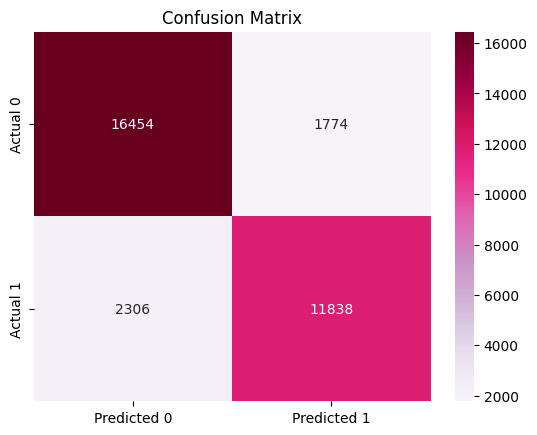

In [15]:
# Create a heatmap of the confusion matrix
sns.heatmap(training_matrix_df, annot=True, cmap='PuRd', fmt='d')

# Add title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [16]:
# Print the classification report for the model
print("Confusion Matrix")
display(training_matrix_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,16454,1774
Actual 1,2306,11838


Accuracy Score : 0.8739651550722847
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     18228
           1       0.87      0.84      0.85     14144

    accuracy                           0.87     32372
   macro avg       0.87      0.87      0.87     32372
weighted avg       0.87      0.87      0.87     32372



In [17]:
# Instantiate the random oversampler model, assign a random_state parameter of 1
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_resampled, y_resampled= ros.fit_resample(X_train, y_train)

In [18]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

0    54997
1    54997
Name: satisfaction, dtype: int64

In [20]:
# Instantiate the Logistic Regression model, assign a random_state parameter of 1
log_classifier = LogisticRegression(solver='liblinear', random_state=1)
log_classifier

# Fit the model using the resampled training data
log_classifier.fit(X_resampled, y_resampled)

# Make a prediction using the testing data
log_predictions = log_classifier.predict(X_test)
log_predictions_df = pd.DataFrame({"Prediction": log_predictions, "Actual": y_test})
log_predictions_df.head()

,Prediction,Actual
9698,0,0
85576,0,0
108838,1,1
89643,0,0
27194,0,0


In [21]:
# Print the balanced_accuracy score of the model 
log_acc_score = balanced_accuracy_score(y_test, log_predictions)
log_acc_score

0.8671421034294611

In [22]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, input_dim=hidden_nodes_layer1, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, input_dim=hidden_nodes_layer2,activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2240      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,701
Trainable params: 4,701
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
3035/3035 [==============================] - 7s 2ms/step - loss: 0.1860 - accuracy: 0.9254
Epoch 2/50
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1221 - accuracy: 0.9502
Epoch 3/50
3035/3035 [==============================] - 6s 2ms/step - loss: 0.1062 - accuracy: 0.9559
Epoch 4/50
3035/3035 [==============================] - 5s 2ms/step - loss: 0.0989 - accuracy: 0.9579
Epoch 5/50
3035/3035 [==============================] - 7s 2ms/step - loss: 0.0956 - accuracy: 0.9594
Epoch 6/50
3035/3035 [==============================] - 5s 2ms/step - loss: 0.0933 - accuracy: 0.9601
Epoch 7/50
3035/3035 [==============================] - 6s 2ms/step - loss: 0.0902 - accuracy: 0.9611
Epoch 8/50
3035/3035 [==============================] - 6s 2ms/step - loss: 0.0892 - accuracy: 0.9614
Epoch 9/50
3035/3035 [==============================] - 5s 2ms/step - loss: 0.0876 - accuracy: 0.9622
Epoch 10/50
3035/3035 [==============================] - 7s 2ms/step - loss: 0.086

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1012/1012 [==============================] - 2s 1ms/step - loss: 0.0973 - accuracy: 0.9593
Loss: 0.09728806465864182, Accuracy: 0.9593166708946228


In [27]:
# Make predictions
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
model_predictions = nn.predict(X_test_scaled)

1012/1012 - 1s - loss: 0.0973 - accuracy: 0.9593 - 1s/epoch - 1ms/step
1012/1012 [==============================] - 2s 2ms/step


In [28]:
# Generate a confusion matrix for the model
model_predictions_new = list(map(lambda x: 0 if x<0.5 else 1, np.transpose(model_predictions)[0]))
cm = confusion_matrix(y_test, model_predictions_new)
deep_learn_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
deep_learn_df

,Predicted 0,Predicted 1
Actual 0,17709,519
Actual 1,798,13346


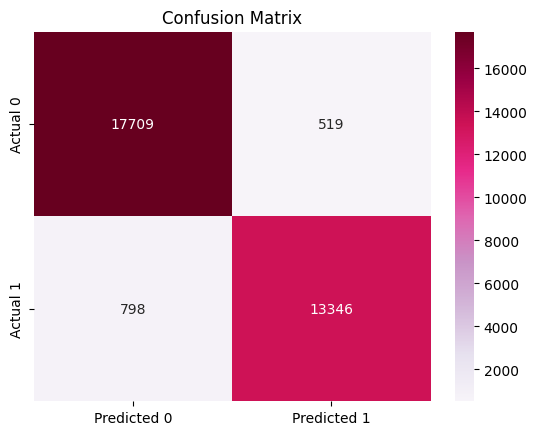

In [29]:
# Create a heatmap of the confusion matrix (deep learning)
sns.heatmap(deep_learn_df, annot=True, cmap='PuRd', fmt='d')

# Add title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [30]:
# Export our model to HDF5 file
nn.save('Airlines_Optimization.h5')